In [ ]:
import multiprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
import sklearn.preprocessing
from sklearn import metrics
from scipy.stats import zscore
from keras.layers import Dense
from keras.optimizers import Adam


In [ ]:
train_data = pd.read_csv('KDDTrain+.txt')  # Replace with the actual path
test_data = pd.read_csv('KDDTest+.txt')    # Replace with the actual path

# Data preprocessing
label_encoder = LabelEncoder()

In [ ]:
train_data.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level']

test_data.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level']

In [ ]:
train_data = train_data.drop('difficulty_level', 1)
test_data = test_data.drop('difficulty_level', 1)

<ipython-input-4-738fcc5837d9>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_data = train_data.drop('difficulty_level', 1)
<ipython-input-4-738fcc5837d9>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_data = test_data.drop('difficulty_level', 1)


In [ ]:
cols = ['protocol_type','service','flag']
cols

['protocol_type', 'service', 'flag']

In [ ]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, 1)
    return df

In [ ]:
combined_data = pd.concat([train_data,test_data])

In [ ]:
combined_data = one_hot(combined_data,cols)

<ipython-input-6-b15a0e689858>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)
<ipython-input-6-b15a0e689858>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)
<ipython-input-6-b15a0e689858>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)


In [ ]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
tmp = combined_data.pop('subclass')

In [ ]:
new_train_df = normalize(combined_data,combined_data.columns)
new_train_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,3.824902e-07,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,6.077927e-07,0.001582,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,5.213394e-07,0.000081,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22538,0.0,2.080118e-06,0.000065,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22539,0.0,8.304754e-07,0.000182,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0.0,1.428837e-04,0.001613,0.0,0.0,0.0,0.019802,0.0,1.0,0.001131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0.0,1.100314e-07,0.000008,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
#Fixing labels for training set
classlist = []
check1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
check2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
check3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
check4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")

DoSCount=0
ProbeCount=0
U2RCount=0
R2LCount=0
NormalCount=0

for item in tmp:
    if item in check1:
        classlist.append("DoS")
        DoSCount=DoSCount+1
    elif item in check2:
        classlist.append("Probe")
        ProbeCount=ProbeCount+1
    elif item in check3:
        classlist.append("U2R")
        U2RCount=U2RCount+1
    elif item in check4:
        classlist.append("R2L")
        R2LCount=R2LCount+1
    else:
        classlist.append("Normal")
        NormalCount=NormalCount+1

In [ ]:
#Appending class column to training set
new_train_df["Class"] = classlist
new_train_df

<ipython-input-14-d6b1aab27504>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_train_df["Class"] = classlist


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,Class
0,0.0,3.824902e-07,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
1,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,DoS
2,0.0,6.077927e-07,0.001582,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
3,0.0,5.213394e-07,0.000081,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
4,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22538,0.0,2.080118e-06,0.000065,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
22539,0.0,8.304754e-07,0.000182,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
22540,0.0,1.428837e-04,0.001613,0.0,0.0,0.0,0.019802,0.0,1.0,0.001131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,DoS
22541,0.0,1.100314e-07,0.000008,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal


In [ ]:
y_train=new_train_df["Class"]
y_train

0        Normal
1           DoS
2        Normal
3        Normal
4           DoS
          ...  
22538    Normal
22539    Normal
22540       DoS
22541    Normal
22542     Probe
Name: Class, Length: 57102, dtype: object

In [ ]:
class_mapping = {
    'Normal': 0,  # Assign a unique integer not found in the dataset
    'DoS': 1,
    'Probe': 2,
    'R2L' : 3,
    'U2R' : 4,
    # Add mappings for other classes
}

# Apply label encoding with the custom mapping
y_train = y_train.map(class_mapping)

In [ ]:
label_encoder = LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_train

array([0, 1, 0, ..., 1, 0, 2])

In [ ]:
combined_data_X = new_train_df.drop('Class', 1)
combined_data_X

<ipython-input-18-1e2f156eda92>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  combined_data_X = new_train_df.drop('Class', 1)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,3.824902e-07,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,6.077927e-07,0.001582,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,5.213394e-07,0.000081,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22538,0.0,2.080118e-06,0.000065,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22539,0.0,8.304754e-07,0.000182,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0.0,1.428837e-04,0.001613,0.0,0.0,0.0,0.019802,0.0,1.0,0.001131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0.0,1.100314e-07,0.000008,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
#accuracies=[]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score

def train_model(model_function, input_shape, num_classes, X_train, Y_train, X_validation, Y_validation):
    accuracies = []  # Initialize an empty list to store accuracy values

    model = model_function(input_shape, num_classes)
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    Y_train_encoded = to_categorical(Y_train, num_classes=num_classes)
    Y_validation_encoded = to_categorical(Y_validation, num_classes=num_classes)

    model.fit(X_train, Y_train_encoded, epochs=10, batch_size=32, verbose=0)
    accuracy = model.evaluate(X_validation, Y_validation_encoded, verbose=0)[1]
    accuracies.append(accuracy)

    predictions = model.predict(X_validation)

    # Convert one-hot encoded predictions back to class labels
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate precision, recall, and F1 score
    precision = precision_score(Y_validation, predicted_classes, average='weighted')
    recall = recall_score(Y_validation, predicted_classes, average='weighted')
    f1 = f1_score(Y_validation, predicted_classes, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return predictions


In [ ]:
def create_model_1(input_shape, num_classes):
    model = Sequential()
    model.add(Convolution1D(64, kernel_size=122, padding="same", activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer with 5 units for multi-class classification
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
def create_model_2(input_shape, num_classes):
    lstm_output_size = 70

    cnn = Sequential()
    cnn.add(Convolution1D(64, kernel_size=3, padding="same", activation="relu", input_shape = input_shape))
    cnn.add(MaxPooling1D(pool_size=2))

    # Add an LSTM layer (assuming 'lstm_output_size' is defined)
    cnn.add(LSTM(units=lstm_output_size))
    cnn.add(Dropout(0.1))
    cnn.add(Dense(1, activation="sigmoid"))
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn

In [ ]:
def create_model_3(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=input_shape[0]))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
X_train, X_validation, Y_train, Y_validation = train_test_split(combined_data_X, y_train, test_size=0.2, random_state=42)


In [ ]:
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_validation = X_validation.values.reshape(X_validation.shape[0], X_validation.shape[1], 1)


In [ ]:
from keras.utils import to_categorical

# One-hot encode the target labels
Y_train_encoded = to_categorical(Y_train, num_classes=5)
Y_validation_encoded = to_categorical(Y_validation, num_classes=5)


In [ ]:
pool = multiprocessing.Pool(processes=3)


In [ ]:

class_mapping = {
    'Normal': 0,  # Assign a unique integer not found in the dataset
    'DoS': 1,
    'Probe': 2,
    'R2L' : 3,
    'U2R' : 4,
    # Add mappings for other classes
}

# Apply label encoding with the custom mapping
new_train_df['Class'] = new_train_df['Class'].map(class_mapping)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
new_train_df['Class'] = label_encoder.fit_transform(new_train_df['Class'])

In [ ]:
new_train_df['Class'].head(10)

0    0
1    1
2    0
3    0
4    1
5    1
6    1
7    1
8    1
9    1
Name: Class, dtype: int64

In [ ]:
from multiprocessing import Pool
import numpy as np

model_functions = [create_model_1, create_model_2, create_model_3]

with Pool() as pool:
    # Use starmap to train multiple models in parallel and get predictions
    model_predictions = pool.starmap(
        train_model,
        [(model_function, X_train.shape[1:], len(new_train_df['Class'].unique()), X_train, Y_train, X_validation, Y_validation) for model_function in model_functions]
    )

weights = [1, 1, 0.6]

ensemble_predictions = np.zeros_like(model_predictions[0])

for i, weight in enumerate(weights):
    weighted_predictions = model_predictions[i] * weight
    ensemble_predictions += weighted_predictions

# Calculate the final ensemble prediction by taking the class with the maximum sum of weighted predictions
ensemble_predictions = np.argmax(ensemble_predictions, axis=1)

ensemble_accuracy = np.mean(ensemble_predictions == Y_validation)

print("Ensemble Model Accuracy:", ensemble_accuracy)


929/929 [==============================] - 5s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9379860758781433
Precision: 0.9159469849236157
Recall: 0.937986062013938
F1 Score: 0.9266108568560854
929/929 [==============================] - 6s 5ms/step
Accuracy: 0.9873076677322388
Precision: 0.9878863783656466
Recall: 0.9873076793589873
F1 Score: 0.9874569001637872
929/929 [==============================] - 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9859610199928284
Precision: 0.9858163929262993
Recall: 0.985961014038986
F1 Score: 0.9858147019608113
Ensemble Model Accuracy: 0.9879473453859879


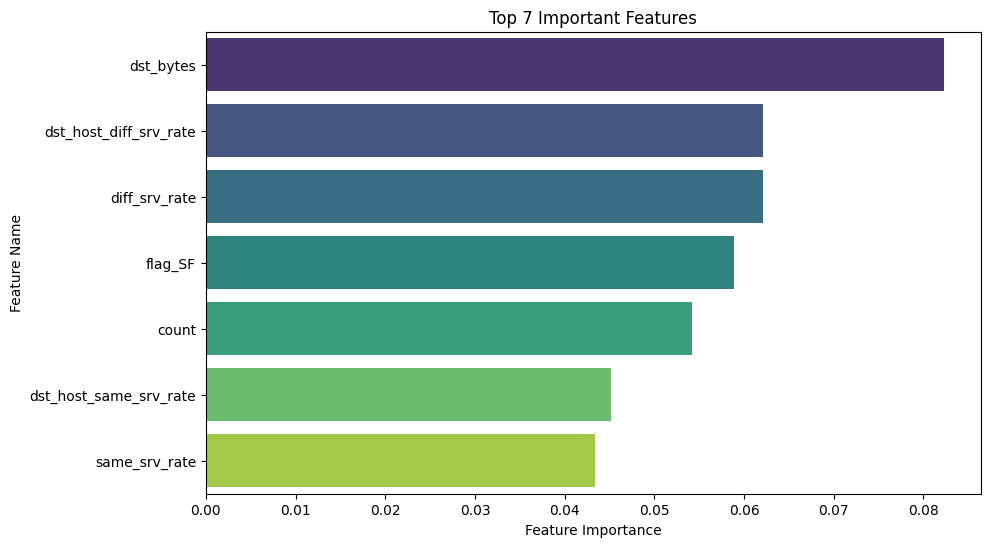

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


X_train = new_train_df.drop('Class', axis=1)
y_train = new_train_df['Class']


imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)


rf_classifier = RandomForestClassifier()


rf_classifier.fit(X_train_imputed, y_train)


feature_importances = rf_classifier.feature_importances_


feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})



feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


# Select the top 7 important features
top_7_features = feature_importance_df.head(7)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_7_features, palette='viridis')


plt.title('Top 7 Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')


plt.show()
